# Solve the NN driven model in a scene

## Import libraries

In [1]:
# Python libraries
import os
import pandas as pd # for data manipulation
import numpy as np # for data manipulation
import tensorflow as tf
import matplotlib.pyplot as plt

# To enable LaTeX and select a font
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

# Using ipynb import functions defined in other nb
from ipynb.fs.defs.myfun_load_dataset import *
from ipynb.fs.defs.myfun_models_STD import *
from ipynb.fs.defs.myfun_plot import *

2023-08-29 13:24:23.563674: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensorflow/Keras: 2.11.0
sklearn: 1.3.0


## Data Acquisition

In [2]:
# Load the dataset
par_dir = os.path.dirname(os.getcwd()) # parent dir
dir_name = par_dir + "/NN-interaction"
merged_df, dflist = load_dataset(dir_name, 'post') # we have 10 pandas dataframe, one for each couple(camera,sequence)

In [3]:
# For sake of simplicity conseder only a scene
df = dflist[0] # sequence
scn = df.T[5]  # scene

In [4]:
scn

Tarr                         [148.04, 148.23999999999998, 148.44]
Xarr            [[48.201888758537635, 52.58811573357667, 57.22...
cons_dis        [[12.802741302154757, 13.596920632589942, 15.6...
N. vehicles                                                     3
cam                                                             1
day                                                             1
seq                                                             1
N. file                                                         1
Xarr_std        [[-0.42946882822049576, -0.18367331685189034, ...
XarrMean                                                55.865771
XarrStd                                                 17.845025
cons_dis_std    [[0.7174403794402562, 0.7619446232364759, 0.87...
Name: 5, dtype: object

In [5]:
# Useful params
N = scn['N. vehicles']
tstamps = scn['Tarr']

In [6]:
scn['Xarr']

array([[48.20188876, 52.58811573, 57.22339205],
       [61.00463006, 66.18503637, 72.82565786],
       [73.44573965, 78.82936684, 84.63510644]])

In [7]:
scn['Xarr_std']

array([[-0.42946883, -0.18367332,  0.07607843],
       [ 0.28797155,  0.57827131,  0.95039864],
       [ 0.9851468 ,  1.28683466,  1.61217686]])

## Just to know the input of the NN

In [8]:
# Just to see what will be the X and y for our NN
X_arr, y_arr = create_data_ann_scene(scn)

In [9]:
print(f"We solve the NN driven ODE sys in each time interval of len=0.2s inside [{tstamps[0]},{tstamps[-1]}].\n")

We solve the NN driven ODE sys in each time interval of len=0.2s inside [148.04,148.44].



In [10]:
print(f"In the first time interval [{tstamps[0]},{tstamps[1]}] we evaluate our NN using as:\n\
\t * X: {X_arr[:,1]} (consecutive distances btw the {N} vehicles)\n\
\t * y: {y_arr[:,1]} (approximated velocities)")

In the first time interval [148.04,148.23999999999998] we evaluate our NN using as:
	 * X: [0.76194462 0.70856335] (consecutive distances btw the 3 vehicles)
	 * y: [1.29875873 1.86063668] (approximated velocities)


## Create the model NN

In [11]:
DOE =[[1,2,1]] #Design of experiment

# Create the model
model = create_model(DOE[0])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden-Layer-1 (Dense)      (None, 2)                 4         
                                                                 
 Output-Layer (Dense)        (None, 1)                 3         
                                                                 
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


## Evaluate the NN in each time interval

In [12]:
# DEFAULT TRAINING NN
epochs = 200           # An epoch is an iteration over the entire x and y data provided
batch_size = 5       # Number of samples per gradient update.
v0 = 30
deltat = 0.05

In [13]:
t_def, x_def, _ = solve_nn_scn_default(model, scn, batch_size, epochs, v0, deltat, verbose=0)

We have 2 time intervals inside [148.04,148.44]

----------------------------------------------------------------------------------------------------
Time interval n.0: [148.04, 148.24]

        * X: [0.71744038 0.69717525]
        * y_true: [1.22897756 1.45149878]
        * y_pred: [1.6125304698944092, 1.601649522781372]
        * v_ann: [1.6125304698944092, 1.601649522781372, 30.0]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Time interval n.1: [148.24, 148.44]

        * X: [0.76194462 0.70856335]
        * y_true: [1.29875873 1.86063668]
        * y_pred: [1.6210227012634277, 1.5924487113952637]
        * v_ann: [1.6210227012634277, 1.5924487113952637, 30.0]

----------------------------------------------------------------------------------------------------


In [14]:
# CUSTOM TRAINING NN
LEARNING_RATE_NN = 0.01
tol = 10

In [15]:
t_cus, x_cus, _ = solve_nn_scn_custom(model, scn, v0, LEARNING_RATE_NN)

We have 2 time intervals inside [148.04,148.44]

----------------------------------------------------------------------------------------------------
Time interval n.0: [148.04, 148.24]

        * X: [0.71744038 0.69717525]
        * y_true: [1.22897756 1.45149878]
        * y_pred: [1.5971746444702148, 1.5864014625549316]
        * v_ann: [1.5971746444702148, 1.5864014625549316, 30.0]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Time interval n.1: [148.24, 148.44]

        * X: [0.76194462 0.70856335]
        * y_true: [1.29875873 1.86063668]
        * y_pred: [1.600780725479126, 1.5725388526916504]
        * v_ann: [1.600780725479126, 1.5725388526916504, 30.0]

----------------------------------------------------------------------------------------------------


### Plot

In [16]:
# Params for the plot
trajs = [scn['Xarr'], np.array(x_def),  np.array(x_cus)]
labels_plot = ["true", "nn sim default", "nn sim custom"]
title = f"Trajs simulated by NN driven LWR model"

In [17]:
def std_back(x,scn):
    return scn['XarrStd']*x + scn['XarrMean'] 

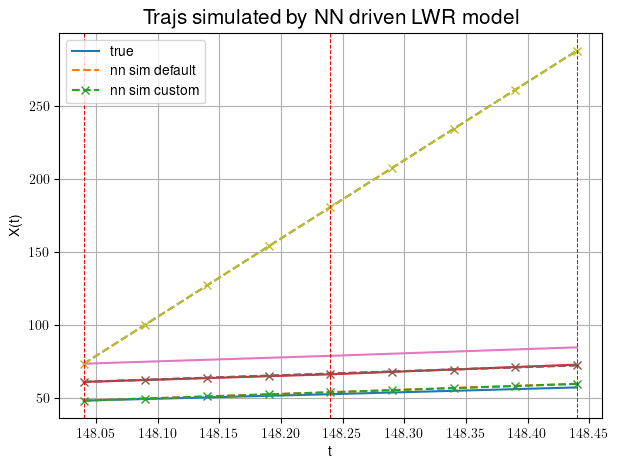

In [28]:
# fig 
width, height = 7, 5
fig, ax = plt.subplots(figsize=(width,height))

for veh in range(0,N):
    ax.plot(tstamps, scn['Xarr'][veh])
    ax.plot(t_def, std_back(x_def[veh],scn), '--')
    ax.plot(t_cus, std_back(x_cus[veh],scn), '--x')


for ts in tstamps:
    ax.axvline(x = ts, color = 'red', linestyle = '--', linewidth=0.75)
    
# Annotate the name of each variable at the last value
plot_annotation(ax, scn, trajs, scale=1.004)

ax.set_xlabel("t")
ax.set_ylabel("X(t)")
ax.set_title(title, fontsize=15)
# Limits for the plot
#plot_limits(ax, scn, trajs, xbal=0, ybal=0.05)
plt.legend(labels_plot)
plt.grid()
plt.show()

## Match the computed solution to the same timestamps of the scene

In [19]:
# To recover the same timestep in the data
factor = int(0.2/deltat)

if len(set(tstamps - np.array(t_def)[::factor])) == 1:
    print(f"timestamps coincide!")
    print("* tstamps: \t\t\t", tstamps,\
          "\n* np.array(t_ann_list): \t",np.array(t_def)[::factor])
else:
    print(f"There is a mismatch in the timestamps: tstamps != tspan[::factor]")

timestamps coincide!
* tstamps: 			 [148.04 148.24 148.44] 
* np.array(t_ann_list): 	 [148.04 148.24 148.44]


In [20]:
## To match solution and timestamps
t_ann = np.array(t_def)[::factor]
x_ann = np.array([traj[::factor] for traj in x_def])